# Data Preparation


## Importación de librerías y carga de datos

Se instalan las dependencias a utilizar.

In [5]:
#Si se realizara una instalación de todas las dependencias en un solo comando, sería:

# pip install mne gdown scipy numpy pandas seaborn matplotlib torch torchvision scikit-learn torchsummary

#Si en caso se trabaja local y tiene anaconda instalado, solo seleccionar 
# el kernel o hacer el pip install en el terminal.

In [ ]:
import os #Para manejo de archivos y directorios
import mne #Para procesamiento de señales EEG
import math
import copy #Para hacer copias profundas de objetos
import gdown #Sirve para descargar archivos de Google Drive
import random
import scipy.io #Para trabajar con archivos .mat
import numpy as np #Para operaciones numéricas
import pandas as pd
import seaborn as sn #Para visualización de datos
import matplotlib.pyplot as plt #Para visualización de datos

# Torch
import torch
import torch.nn as nn #Para construir redes neuronales
import torch.optim as optim #Para optimizadores
import torch.nn.functional as F #Para funciones de activación y pérdida

from torchsummary import summary #Para resumir modelos de PyTorch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, random_split

# Scikit-Learn
from sklearn.feature_selection import mutual_info_classif #Para selección de características
from sklearn.metrics import confusion_matrix, accuracy_score #Para evaluar el rendimiento del modelo
from sklearn.model_selection import train_test_split #Para dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.decomposition import PCA #Para análisis de componentes principales

Se cargan las bases de datos a utilizar
> Link de la descripción del dataset 2a: https://www.bbci.de/competition/iv/desc_2a.pdf

> Link de la descripción del dataset 2b: https://www.bbci.de/competition/iv/desc_2b.pdf

In [10]:
#Descarga directamente el dataset de BCI Competition IV 2a
!wget https://www.bbci.de/competition/download/competition_iv/BCICIV_2a_gdf.zip
!wget https://www.bbci.de/competition/download/competition_iv/BCICIV_2b_gdf.zip

# Descomprime los datos en crudo en raw_data
!unzip BCICIV_2a_gdf.zip -d raw_data_2a
!unzip BCICIV_2b_gdf.zip -d raw_data_2b

--2025-12-07 18:31:33--  https://www.bbci.de/competition/download/competition_iv/BCICIV_2a_gdf.zip
Resolviendo www.bbci.de (www.bbci.de)... 141.23.71.83
Conectando con www.bbci.de (www.bbci.de)[141.23.71.83]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 439968864 (420M) [application/zip]
Grabando a: «BCICIV_2a_gdf.zip»

BCICIV_2a_gdf.zip   100%[===================>] 419.59M  5.65MB/s    en 88s     

2025-12-07 18:33:03 (4.78 MB/s) - «BCICIV_2a_gdf.zip» guardado [439968864/439968864]

--2025-12-07 18:33:03--  https://www.bbci.de/competition/download/competition_iv/BCICIV_2b_gdf.zip
Resolviendo www.bbci.de (www.bbci.de)... 141.23.71.83
Conectando con www.bbci.de (www.bbci.de)[141.23.71.83]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 226710550 (216M) [application/zip]
Grabando a: «BCICIV_2b_gdf.zip»

BCICIV_2b_gdf.zip   100%[===================>] 216.21M  5.64MB/s    en 45s     

2025-12-07 18:33:49 (4.84 MB/s) - «BCI

## Preprocesamiento: limpieza, filtrado y segmentación

Eliminamos los canales de EOG y extraemos los datos de los primeros ejemplos de entrenamiento en ambos database:

### Database 2a

In [109]:
# Database 2a ejemplo 1 de entrenamiento 
raw_A01T = mne.io.read_raw_gdf('raw_data_2a/A01T.gdf', eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)

# Elimina cualquier canal marcado como EOG para que solo queden EEG
eog_channels = [name for name in raw_A01T.info['ch_names'] if 'EOG' in name.upper()]
if eog_channels:
    raw_A01T.drop_channels(eog_channels)
raw_A01T.info


Extracting EDF parameters from /Users/miguel_05/Desktop/Academico/Universidad/Octavo Ciclo/NeuroMotionXR_pipeline/raw_data_2a/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/opt/anaconda3/envs/dl_env/lib/python3.11/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


<Info | 8 non-empty values
 bads: []
 ch_names: EEG-Fz, EEG-0, EEG-1, EEG-2, EEG-3, EEG-4, EEG-5, EEG-C3, EEG-6, ...
 chs: 22 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 2005-01-17 12:00:00 UTC
 nchan: 22
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: A01, sex: 0, last_name: X, birthday: 1983-01-17>
>

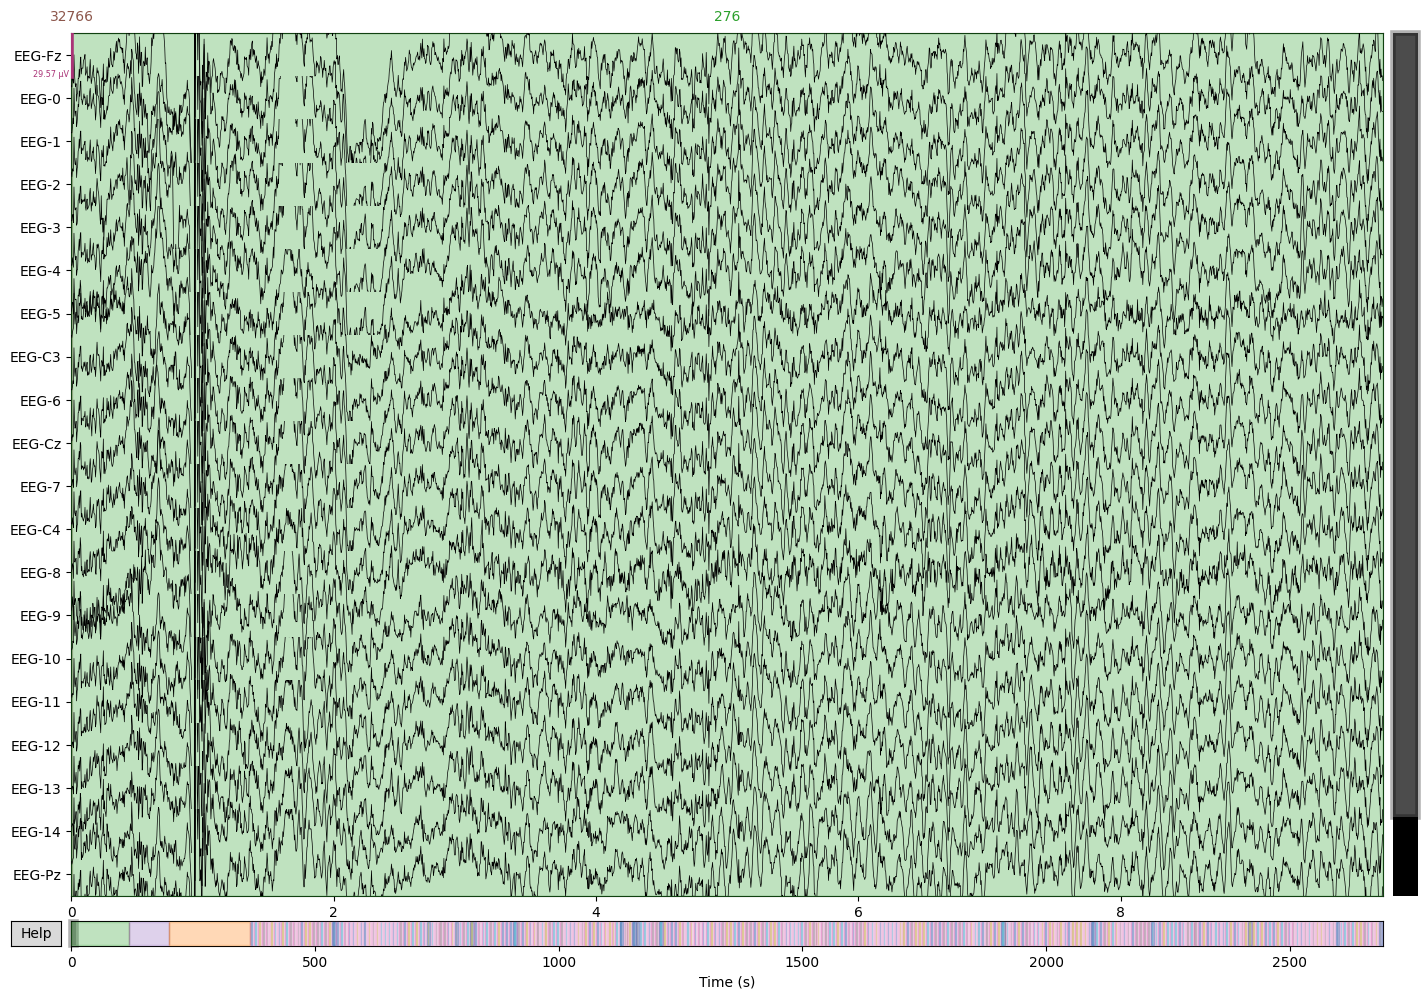

In [110]:
#Plot de la DATA CRUDA
fig = raw_A01T.plot(scalings='auto', show=False)
fig.set_size_inches(15, 10)
plt.show()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB



Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



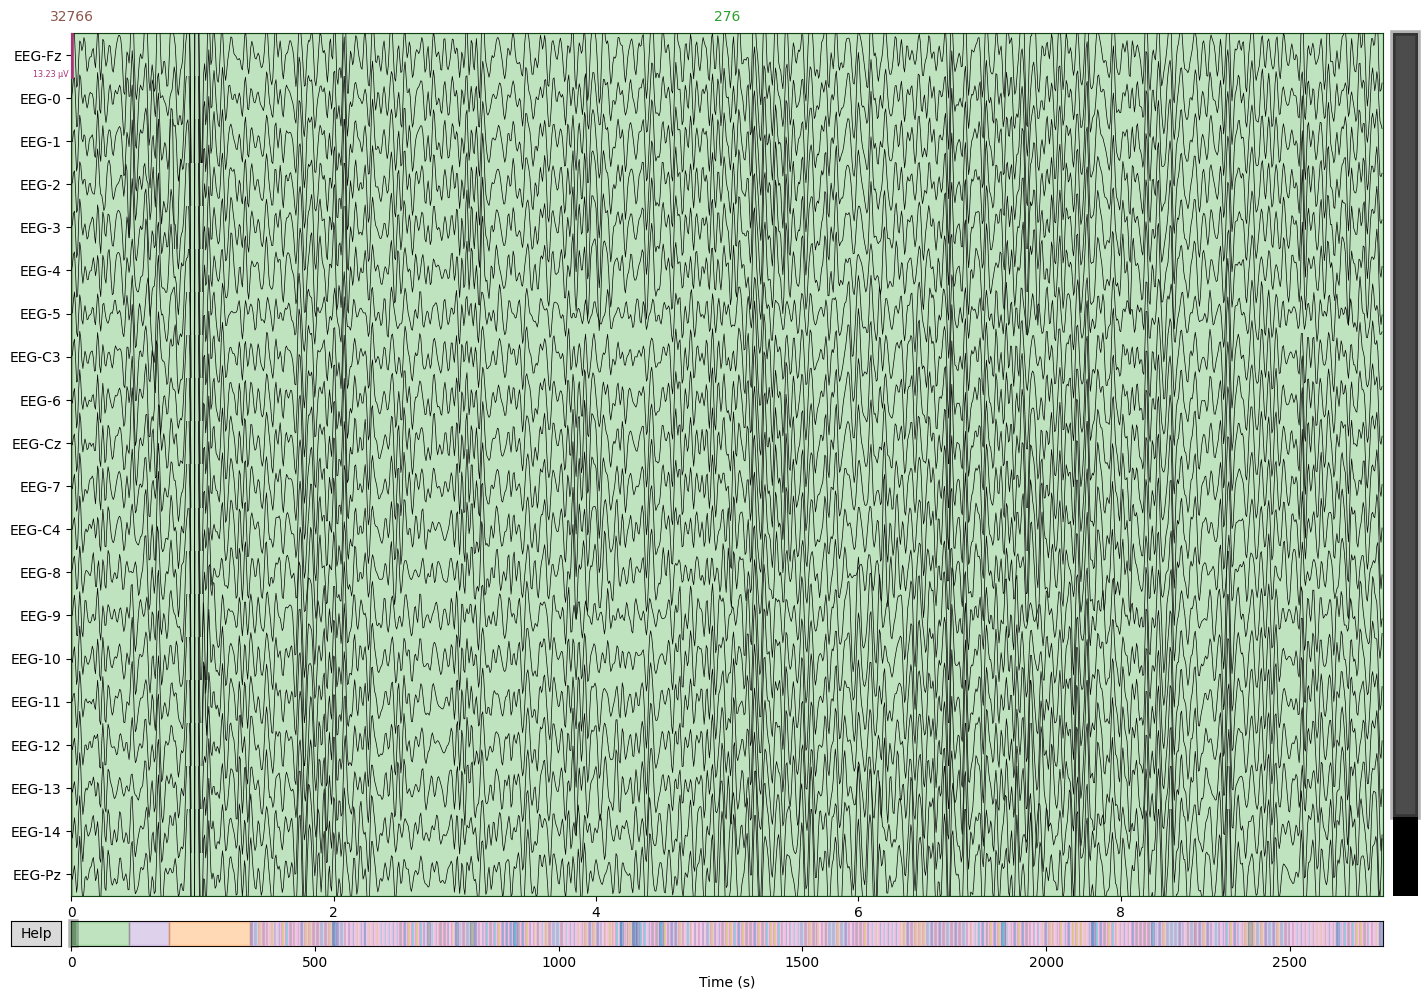

In [111]:
raw_A01T.filter(l_freq=8, h_freq=30, method='iir')
raw_A01T.notch_filter(freqs=50)

#Plot de la data
fig = raw_A01T.plot(scalings='auto', show=False)
fig.set_size_inches(15, 10)
plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/opt/anaconda3/envs/dl_env/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


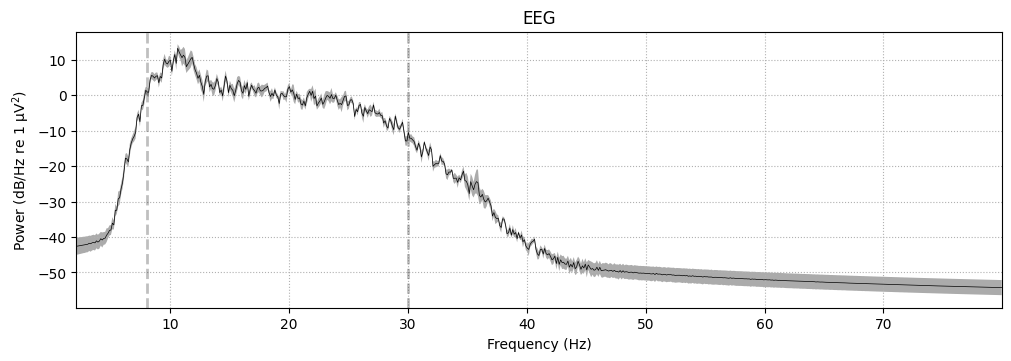

In [112]:
raw_A01T.plot_psd(tmin=0, tmax=60, fmin=2, fmax=80, average=True, spatial_colors=False);
plt.show()

Sin embargo, necesitamos de una epoch: especificamente donde se obtuve las SMR mediante imageneria motora en el evento de right or left

In [113]:
# Convierte las anotaciones textuales en eventos numéricos
raw_A01T.annotations
events = mne.events_from_annotations(raw_A01T)
events[1]

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


{'1023': 1,
 '1072': 2,
 '276': 3,
 '277': 4,
 '32766': 5,
 '768': 6,
 '769': 7,
 '770': 8,
 '771': 9,
 '772': 10}

Eventos a lo largo del recording para la sesión de la persona

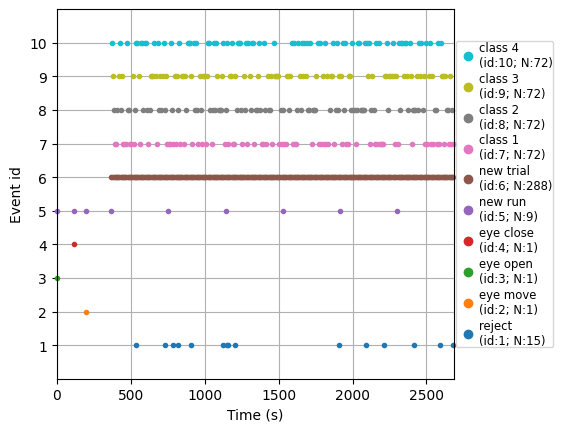

In [114]:
event_dict={
    'reject':1,
    'eye move':2,
    'eye open':3,
    'eye close':4,
    'new run':5,
    'new trial':6,
    'class 1':7,
    'class 2':8,
    'class 3':9,
    'class 4':10,
}
fig = mne.viz.plot_events(events[0], event_id=event_dict, sfreq=raw_A01T.info['sfreq'],
                            first_samp=raw_A01T.first_samp)

In [115]:
mi_event_id = {name: idx for name, idx in event_dict.items() if name.startswith('class')}
print('Eventos MI disponibles:', mi_event_id)



Eventos MI disponibles: {'class 1': 7, 'class 2': 8, 'class 3': 9, 'class 4': 10}


In [116]:
# Crear epochs para los eventos de interés (clases MI) incluyendo 0.5 s pre-evento
epochs = mne.Epochs(raw_A01T, events[0], event_id=mi_event_id, tmin=-0.5, tmax=4, reject=None, baseline=None, preload=True)

# Extraer los datos y las etiquetas de las epochs
first_session_data= epochs.get_data(copy=True)

# Etiquetas de las primeras sesiones
first_session_labels = epochs.events[:,-1]

Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...


0 bad epochs dropped


In [117]:
# VERIFICACIÓN: Contar cuántos trials hay de cada clase y confirmar el mapeo correcto
print("="*80)
print("VERIFICACIÓN DE ETIQUETAS Y DISTRIBUCIÓN DE CLASES")
print("="*80)
print(f"\nTotal de epochs: {len(epochs)}")
print(f"\nDistribución por clase:")
for class_name, class_id in mi_event_id.items():
    count = np.sum(first_session_labels == class_id)
    print(f"  {class_name} (evento {class_id}): {count} trials ({count/len(epochs)*100:.1f}%)")

# Según la documentación del BCI Competition IV 2a:
# Class 1 (evento 7): Left hand (mano izquierda)
# Class 2 (evento 8): Right hand (mano derecha)
# Class 3 (evento 9): Both feet (ambos pies)
# Class 4 (evento 10): Tongue (lengua)

print("\n" + "="*80)
print("MAPEO DE CLASES SEGÚN DOCUMENTACIÓN BCI Competition IV 2a:")
print("="*80)
print("  Class 1 (evento 7) → Left hand (mano izquierda)")
print("  Class 2 (evento 8) → Right hand (mano derecha)")
print("  Class 3 (evento 9) → Both feet (ambos pies)")
print("  Class 4 (evento 10) → Tongue (lengua)")
print("="*80)

# Verificar que tenemos suficientes trials de cada clase de interés
class_1_count = np.sum(first_session_labels == mi_event_id['class 1'])
class_2_count = np.sum(first_session_labels == mi_event_id['class 2'])

print(f"\nVerificación para análisis:")
print(f"  'class 1' (Left hand): {class_1_count} trials → Se usará como 'MI izquierda'")
print(f"  'class 2' (Right hand): {class_2_count} trials → Se usará como 'MI derecha'")

if class_1_count == 0 or class_2_count == 0:
    print("\n⚠️  ADVERTENCIA: Una de las clases no tiene trials!")
else:
    print(f"\n✓ Verificación exitosa: Ambas clases tienen suficientes trials para el análisis")
print("="*80)

# Verificación adicional: Mostrar algunos ejemplos de eventos para confirmar
print("\nEjemplos de eventos (primeros 10):")
print("Tiempo (s)\tEvento ID\tClase")
for i in range(min(10, len(epochs.events))):
    event_time = epochs.events[i, 0] / epochs.info['sfreq']
    event_id = epochs.events[i, 2]
    class_name = [name for name, eid in mi_event_id.items() if eid == event_id]
    class_name = class_name[0] if class_name else 'unknown'
    print(f"{event_time:.2f}\t\t{event_id}\t\t{class_name}")



VERIFICACIÓN DE ETIQUETAS Y DISTRIBUCIÓN DE CLASES

Total de epochs: 288

Distribución por clase:
  class 1 (evento 7): 72 trials (25.0%)
  class 2 (evento 8): 72 trials (25.0%)
  class 3 (evento 9): 72 trials (25.0%)
  class 4 (evento 10): 72 trials (25.0%)

MAPEO DE CLASES SEGÚN DOCUMENTACIÓN BCI Competition IV 2a:
  Class 1 (evento 7) → Left hand (mano izquierda)
  Class 2 (evento 8) → Right hand (mano derecha)
  Class 3 (evento 9) → Both feet (ambos pies)
  Class 4 (evento 10) → Tongue (lengua)

Verificación para análisis:
  'class 1' (Left hand): 72 trials → Se usará como 'MI izquierda'
  'class 2' (Right hand): 72 trials → Se usará como 'MI derecha'

✓ Verificación exitosa: Ambas clases tienen suficientes trials para el análisis

Ejemplos de eventos (primeros 10):
Tiempo (s)	Evento ID	Clase
369.47		10		class 4
377.48		9		class 3
385.16		8		class 2
392.96		7		class 1
401.00		7		class 1
409.44		8		class 2
417.11		9		class 3
425.31		10		class 4
433.03		8		class 2
441.02		9		class 3


Effective window size : 1.024 (s)
PSDs shape: (288, 22, 42), freqs shape: (42,)
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


/opt/anaconda3/envs/dl_env/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


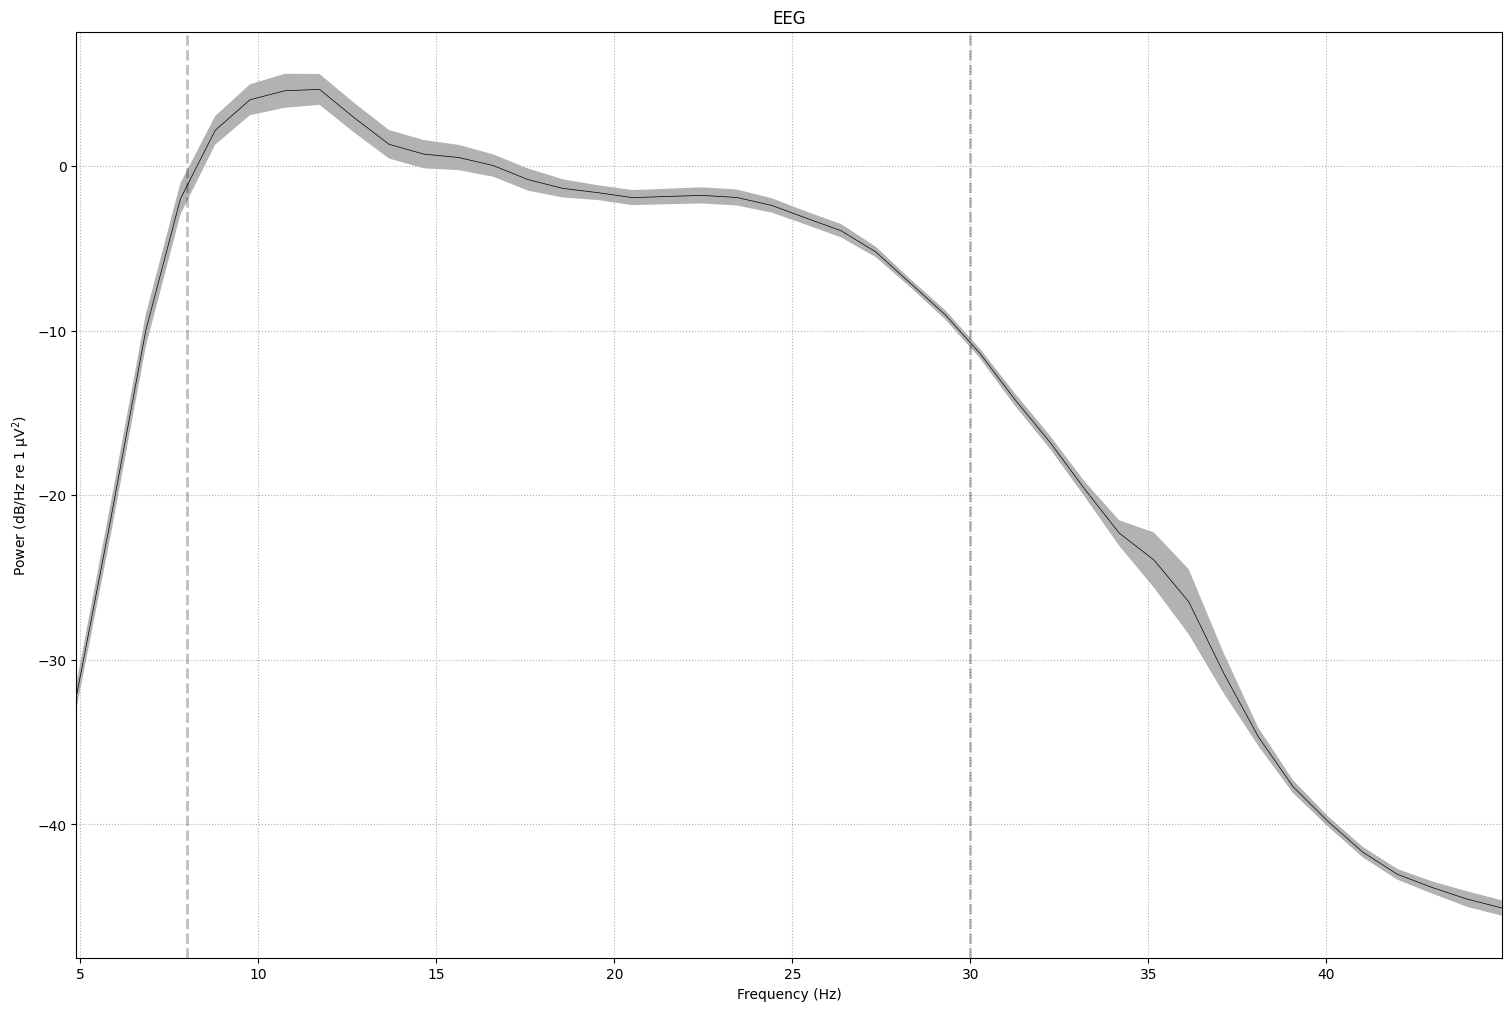

In [118]:
# Calcular la PSD con el método Welch 
epo_spectrum = epochs.compute_psd(method='welch', fmin=4, fmax=45, n_fft=256)

# Obtener datos PSD y sus frecuencias
psds, freqs = epo_spectrum.get_data(return_freqs=True)
print(f"PSDs shape: {psds.shape}, freqs shape: {freqs.shape}")

# Graficar el PSD promedio sobre todos los epochs (por canal)
# average=True: promedio de los 288 trials (no cada trial individual).
fig=epo_spectrum.plot(average=True, dB=True, spatial_colors=True)
fig.set_size_inches(15, 10)
plt.show()

In [119]:
# Calcular TFR para cada clase MI y visualizar ERD/ERS usando mu/beta
# VERIFICACIÓN: Confirmar mapeo correcto de clases
# 'class 1' (evento 7) = Left hand (mano izquierda) → tfr_left ✓
# 'class 2' (evento 8) = Right hand (mano derecha) → tfr_right ✓

print("Creando TFR para análisis de ERD/ERS:")
print(f"  tfr_left ← epochs['class 1'] (Left hand, evento {mi_event_id['class 1']})")
print(f"  tfr_right ← epochs['class 2'] (Right hand, evento {mi_event_id['class 2']})")
print()

freqs = np.arange(8., 31., 1.)
n_cycles = freqs / 2.0

tfr_left = epochs['class 1'].compute_tfr(method='morlet', freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=3, average=True)
tfr_right = epochs['class 2'].compute_tfr(method='morlet', freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=3, average=True)

print(f"✓ TFR creados exitosamente:")
print(f"  tfr_left: {len(epochs['class 1'])} trials de MI izquierda")
print(f"  tfr_right: {len(epochs['class 2'])} trials de MI derecha")

for tfr_object in (tfr_left, tfr_right):
    tfr_object.apply_baseline(baseline=(-0.5, 0), mode='logratio')

output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

def _save_figure(fig, name):
    path = os.path.join(output_dir, name)
    # Manejar tanto figuras individuales como listas de figuras
    if isinstance(fig, list):
        # Si es una lista, guardar la primera figura (o todas si es necesario)
        fig[0].savefig(path)
        for f in fig:
            plt.close(f)
    else:
        fig.savefig(path)
        plt.close(fig)
    print(f'{name} guardado en {path}')

# Crear gráficos TFR/espectrogramas comparando MI izquierda vs derecha para C3 y C4
c3_idx = [i for i, ch in enumerate(tfr_left.ch_names) if 'C3' in ch][0]
c4_idx = [i for i, ch in enumerate(tfr_left.ch_names) if 'C4' in ch][0]

# TFR para C3: comparación izquierda vs derecha (espectrogramas lado a lado)
fig_c3, axes_c3 = plt.subplots(1, 2, figsize=(16, 6))

# C3 - MI Izquierda
c3_left_data = tfr_left.data[c3_idx, :, :]
im1 = axes_c3[0].imshow(c3_left_data, aspect='auto', origin='lower',
                        extent=[tfr_left.times[0], tfr_left.times[-1], freqs[0], freqs[-1]],
                        cmap='RdBu_r', vmin=-0.8, vmax=0.8)
axes_c3[0].axvline(x=0, color='k', linestyle='--', alpha=0.5, linewidth=2)
axes_c3[0].set_title('C3: MI Izquierda', fontsize=12, fontweight='bold')
axes_c3[0].set_xlabel('Tiempo (s)')
axes_c3[0].set_ylabel('Frecuencia (Hz)')
plt.colorbar(im1, ax=axes_c3[0], label='Log-ratio power')

# C3 - MI Derecha
c3_right_data = tfr_right.data[c3_idx, :, :]
im2 = axes_c3[1].imshow(c3_right_data, aspect='auto', origin='lower',
                        extent=[tfr_right.times[0], tfr_right.times[-1], freqs[0], freqs[-1]],
                        cmap='RdBu_r', vmin=-0.8, vmax=0.8)
axes_c3[1].axvline(x=0, color='k', linestyle='--', alpha=0.5, linewidth=2)
axes_c3[1].set_title('C3: MI Derecha', fontsize=12, fontweight='bold')
axes_c3[1].set_xlabel('Tiempo (s)')
axes_c3[1].set_ylabel('Frecuencia (Hz)')
plt.colorbar(im2, ax=axes_c3[1], label='Log-ratio power')

plt.suptitle('C3: Comparación MI Izquierda vs Derecha (8-30 Hz) - Database 2a', fontsize=14, fontweight='bold')
plt.tight_layout()
_save_figure(fig_c3, 'tfr_C3_left_vs_right.png')
plt.close(fig_c3)

# TFR para C4: comparación izquierda vs derecha (espectrogramas lado a lado)
fig_c4, axes_c4 = plt.subplots(1, 2, figsize=(16, 6))

# C4 - MI Izquierda
c4_left_data = tfr_left.data[c4_idx, :, :]
im3 = axes_c4[0].imshow(c4_left_data, aspect='auto', origin='lower',
                        extent=[tfr_left.times[0], tfr_left.times[-1], freqs[0], freqs[-1]],
                        cmap='RdBu_r', vmin=-0.8, vmax=0.8)
axes_c4[0].axvline(x=0, color='k', linestyle='--', alpha=0.5, linewidth=2)
axes_c4[0].set_title('C4: MI Izquierda', fontsize=12, fontweight='bold')
axes_c4[0].set_xlabel('Tiempo (s)')
axes_c4[0].set_ylabel('Frecuencia (Hz)')
plt.colorbar(im3, ax=axes_c4[0], label='Log-ratio power')

# C4 - MI Derecha
c4_right_data = tfr_right.data[c4_idx, :, :]
im4 = axes_c4[1].imshow(c4_right_data, aspect='auto', origin='lower',
                        extent=[tfr_right.times[0], tfr_right.times[-1], freqs[0], freqs[-1]],
                        cmap='RdBu_r', vmin=-0.8, vmax=0.8)
axes_c4[1].axvline(x=0, color='k', linestyle='--', alpha=0.5, linewidth=2)
axes_c4[1].set_title('C4: MI Derecha', fontsize=12, fontweight='bold')
axes_c4[1].set_xlabel('Tiempo (s)')
axes_c4[1].set_ylabel('Frecuencia (Hz)')
plt.colorbar(im4, ax=axes_c4[1], label='Log-ratio power')

plt.suptitle('C4: Comparación MI Izquierda vs Derecha (8-30 Hz) - Database 2a', fontsize=14, fontweight='bold')
plt.tight_layout()
_save_figure(fig_c4, 'tfr_C4_left_vs_right.png')
plt.close(fig_c4)



Creando TFR para análisis de ERD/ERS:
  tfr_left ← epochs['class 1'] (Left hand, evento 7)
  tfr_right ← epochs['class 2'] (Right hand, evento 8)

✓ TFR creados exitosamente:
  tfr_left: 72 trials de MI izquierda
  tfr_right: 72 trials de MI derecha
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
tfr_C3_left_vs_right.png guardado en outputs/tfr_C3_left_vs_right.png
tfr_C4_left_vs_right.png guardado en outputs/tfr_C4_left_vs_right.png


### Database 2b

In [71]:
# Database 2b ejemplo 1 de entrenamiento 
raw_B0101T = mne.io.read_raw_gdf('raw_data_2b/B0101T.gdf', eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)
raw_B0101T.info

Extracting EDF parameters from /Users/miguel_05/Desktop/Academico/Universidad/Octavo Ciclo/NeuroMotionXR_pipeline/raw_data_2b/B0101T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/var/folders/7g/x1f_2rpx6slblmnprfxv_0yr0000gn/T/ipykernel_28032/3377715692.py:2: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw_B0101T = mne.io.read_raw_gdf('raw_data_2b/B0101T.gdf', eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)


<Info | 8 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 6 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2005-10-25 09:35:11 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: B01, sex: 0, last_name: X, birthday: 1984-12-01>
>

In [72]:
# Elimina cualquier canal marcado como EOG para que solo queden EEG
eog_channels_2b = [name for name in raw_B0101T.info['ch_names'] if 'EOG' in name.upper()]
if eog_channels_2b:
    raw_B0101T.drop_channels(eog_channels_2b)
print("Canales EEG después de eliminar EOG:", raw_B0101T.ch_names)



Canales EEG después de eliminar EOG: ['EEG:C3', 'EEG:Cz', 'EEG:C4']


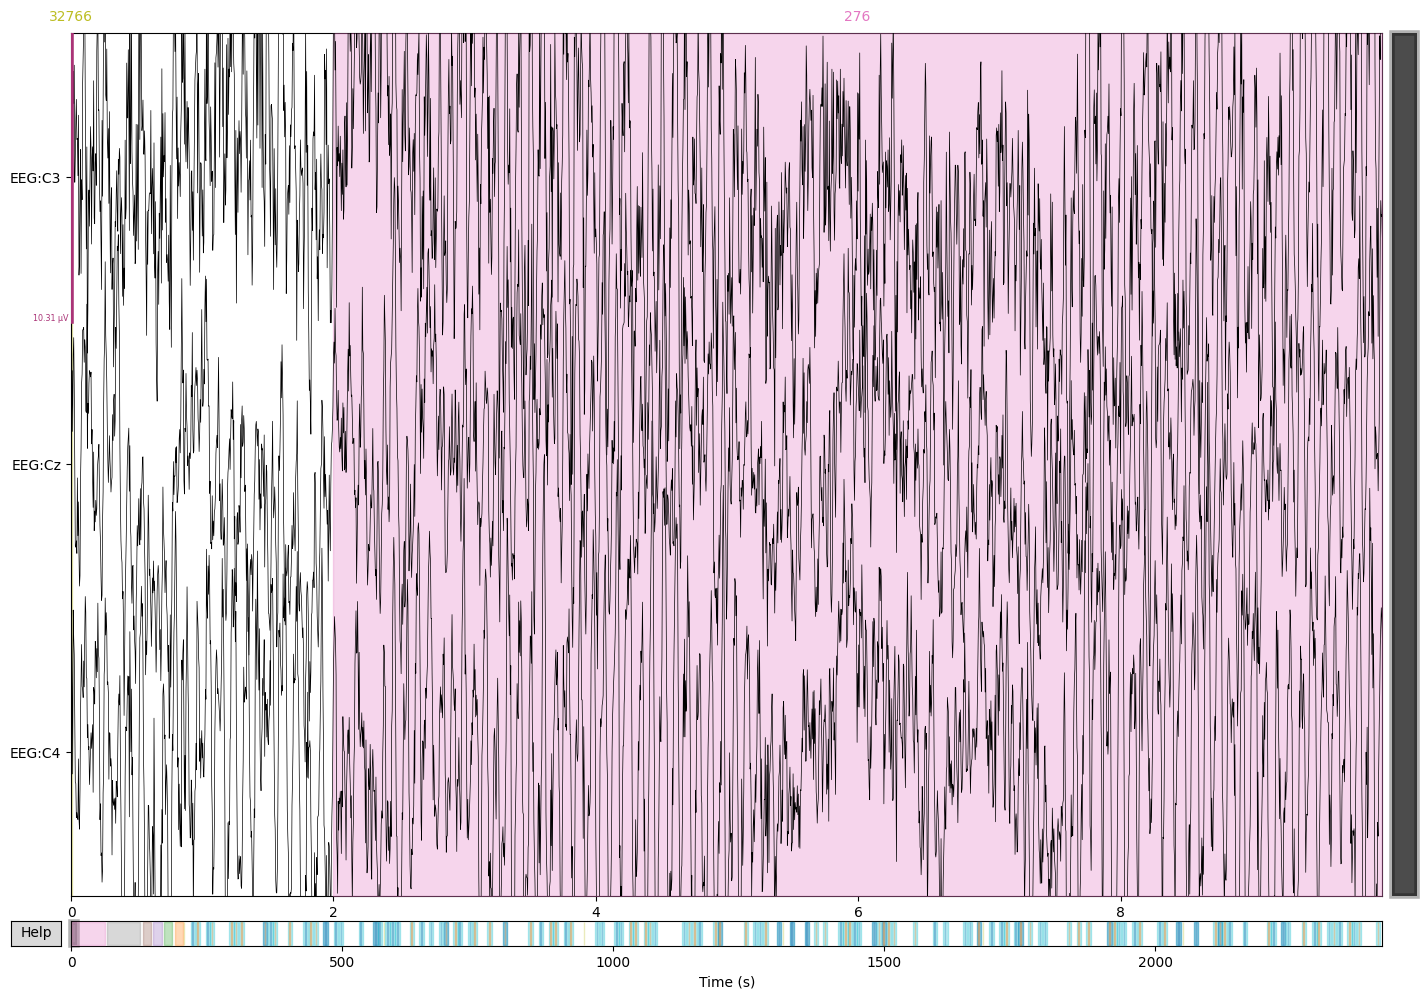

In [73]:
#Plot de la DATA CRUDA - Database 2b
fig = raw_B0101T.plot(scalings='auto', show=False)
fig.set_size_inches(15, 10)
plt.show()



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



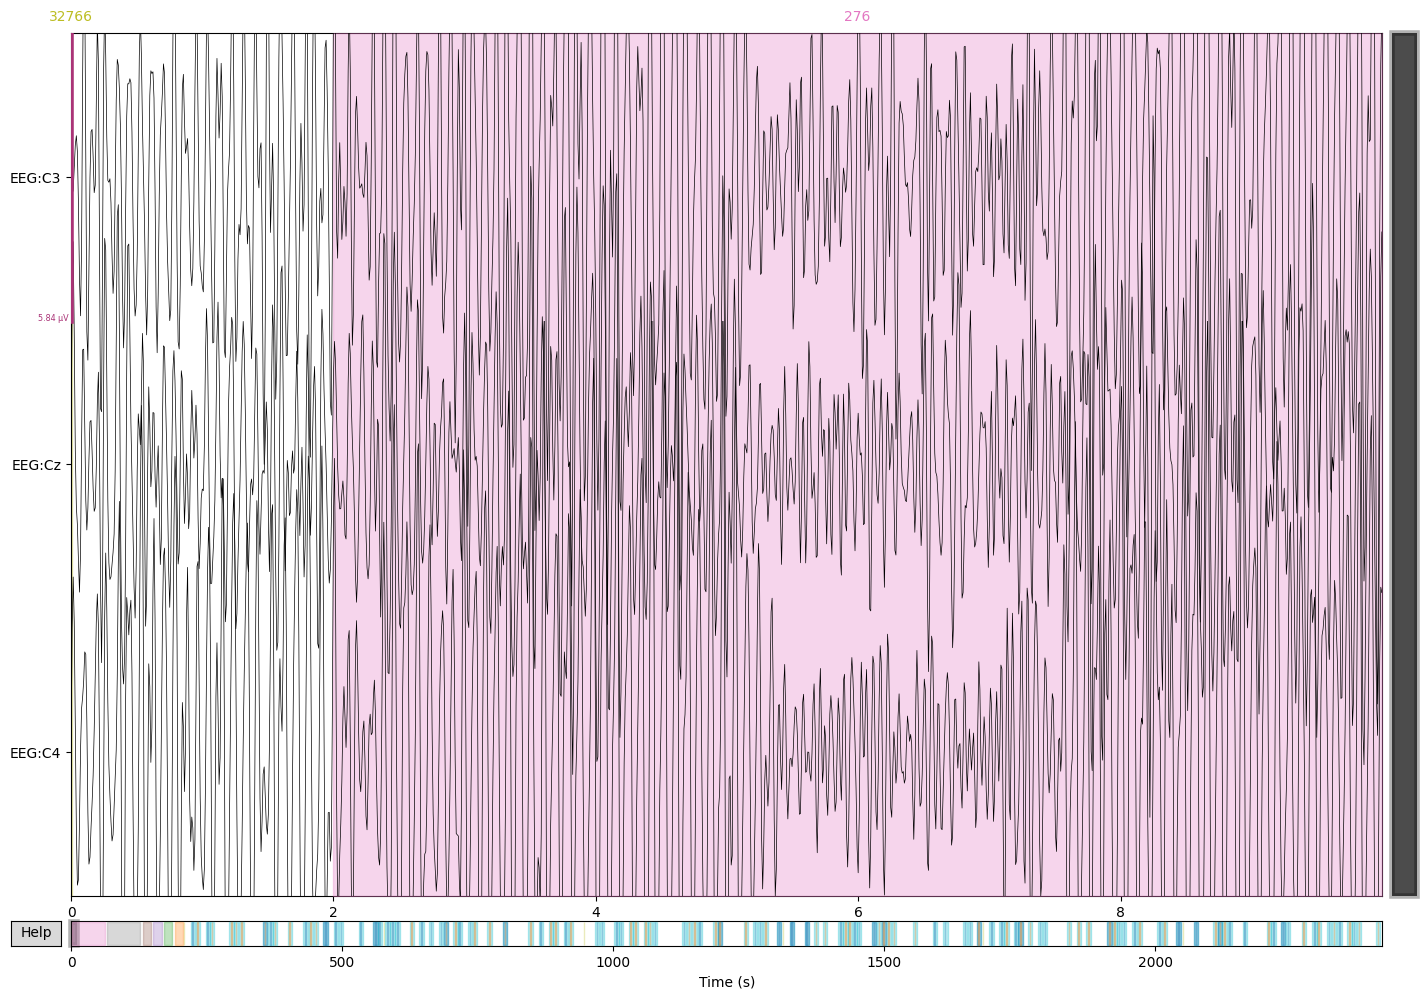

<Info | 8 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4
 chs: 3 EEG
 custom_ref_applied: False
 highpass: 8.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2005-10-25 09:35:11 UTC
 nchan: 3
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: B01, sex: 0, last_name: X, birthday: 1984-12-01>
>

In [75]:
# Filtrado - Database 2b
raw_B0101T.filter(l_freq=8, h_freq=30, method='iir')
raw_B0101T.notch_filter(freqs=50)

#Plot de la data filtrada
fig = raw_B0101T.plot(scalings='auto', show=False)
fig.set_size_inches(15, 10)
plt.show()

raw_B0101T.info


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/opt/anaconda3/envs/dl_env/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


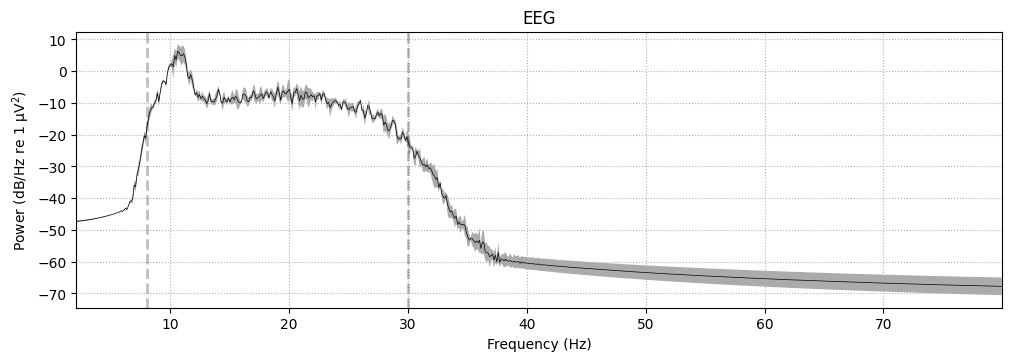

In [76]:
# PSD - Database 2b
raw_B0101T.plot_psd(tmin=0, tmax=60, fmin=2, fmax=80, average=True, spatial_colors=False);
plt.show()



Sin embargo, necesitamos de una epoch: especificamente donde se obtuve las SMR mediante imageneria motora en el evento de right or left (Database 2b)



In [60]:
# Convierte las anotaciones textuales en eventos numéricos - Database 2b
raw_B0101T.annotations
events_2b = mne.events_from_annotations(raw_B0101T)
print("Anotaciones disponibles:", events_2b[1])

# Definir el diccionario de eventos para Database 2b
# Según la documentación BCI Competition IV 2b:
# Evento 769 (mapeado a 10) = Left hand (mano izquierda) → 'class 1'
# Evento 770 (mapeado a 11) = Right hand (mano derecha) → 'class 2'
event_dict_2b = {
    'class 1': 10,  # Left hand (evento 769)
    'class 2': 11,  # Right hand (evento 770)
}

# Crear diccionario solo con eventos MI
mi_event_id_2b = {name: idx for name, idx in event_dict_2b.items() if name.startswith('class')}
print('Eventos MI disponibles (2b):', mi_event_id_2b)



Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Anotaciones disponibles: {'1023': 1, '1077': 2, '1078': 3, '1079': 4, '1081': 5, '276': 6, '277': 7, '32766': 8, '768': 9, '769': 10, '770': 11}
Eventos MI disponibles (2b): {'class 1': 10, 'class 2': 11}


In [61]:
# Crear epochs para los eventos de interés (clases MI) incluyendo 0.5 s pre-evento - Database 2b
epochs_2b = mne.Epochs(raw_B0101T, events_2b[0], event_id=mi_event_id_2b, tmin=-0.5, tmax=4, reject=None, baseline=None, preload=True)

# Extraer los datos y las etiquetas de las epochs
first_session_data_2b = epochs_2b.get_data(copy=True)

# Etiquetas de las primeras sesiones
first_session_labels_2b = epochs_2b.events[:,-1]



Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 120 events and 1126 original time points ...
0 bad epochs dropped


In [62]:
# VERIFICACIÓN: Contar cuántos trials hay de cada clase y confirmar el mapeo correcto - Database 2b
print("="*80)
print("VERIFICACIÓN DE ETIQUETAS Y DISTRIBUCIÓN DE CLASES - Database 2b")
print("="*80)
print(f"\nTotal de epochs: {len(epochs_2b)}")
print(f"\nDistribución por clase:")
for class_name, class_id in mi_event_id_2b.items():
    count = np.sum(first_session_labels_2b == class_id)
    print(f"  {class_name} (evento {class_id}): {count} trials ({count/len(epochs_2b)*100:.1f}%)")

# Según la documentación del BCI Competition IV 2b:
# Evento 769 (mapeado a 10) = Left hand (mano izquierda) → 'class 1'
# Evento 770 (mapeado a 11) = Right hand (mano derecha) → 'class 2'

print("\n" + "="*80)
print("MAPEO DE CLASES SEGÚN DOCUMENTACIÓN BCI Competition IV 2b:")
print("="*80)
print("  Class 1 (evento 10, original 769) → Left hand (mano izquierda)")
print("  Class 2 (evento 11, original 770) → Right hand (mano derecha)")
print("="*80)

# Verificar que tenemos suficientes trials de cada clase de interés
class_1_count_2b = np.sum(first_session_labels_2b == mi_event_id_2b['class 1'])
class_2_count_2b = np.sum(first_session_labels_2b == mi_event_id_2b['class 2'])

print(f"\nVerificación para análisis:")
print(f"  'class 1' (Left hand): {class_1_count_2b} trials → Se usará como 'MI izquierda'")
print(f"  'class 2' (Right hand): {class_2_count_2b} trials → Se usará como 'MI derecha'")

if class_1_count_2b == 0 or class_2_count_2b == 0:
    print("\n⚠️  ADVERTENCIA: Una de las clases no tiene trials!")
else:
    print(f"\n✓ Verificación exitosa: Ambas clases tienen suficientes trials para el análisis")
print("="*80)

# Verificación adicional: Mostrar algunos ejemplos de eventos para confirmar
print("\nEjemplos de eventos (primeros 10):")
print("Tiempo (s)\tEvento ID\tClase")
for i in range(min(10, len(epochs_2b.events))):
    event_time = epochs_2b.events[i, 0] / epochs_2b.info['sfreq']
    event_id = epochs_2b.events[i, 2]
    class_name = [name for name, eid in mi_event_id_2b.items() if eid == event_id]
    class_name = class_name[0] if class_name else 'unknown'
    print(f"{event_time:.2f}\t\t{event_id}\t\t{class_name}")



VERIFICACIÓN DE ETIQUETAS Y DISTRIBUCIÓN DE CLASES - Database 2b

Total de epochs: 120

Distribución por clase:
  class 1 (evento 10): 60 trials (50.0%)
  class 2 (evento 11): 60 trials (50.0%)

MAPEO DE CLASES SEGÚN DOCUMENTACIÓN BCI Competition IV 2b:
  Class 1 (evento 10, original 769) → Left hand (mano izquierda)
  Class 2 (evento 11, original 770) → Right hand (mano derecha)

Verificación para análisis:
  'class 1' (Left hand): 60 trials → Se usará como 'MI izquierda'
  'class 2' (Right hand): 60 trials → Se usará como 'MI derecha'

✓ Verificación exitosa: Ambas clases tienen suficientes trials para el análisis

Ejemplos de eventos (primeros 10):
Tiempo (s)	Evento ID	Clase
223.56		10		class 1
233.00		11		class 2
251.27		10		class 1
259.42		11		class 2
294.92		11		class 2
303.75		11		class 2
313.36		11		class 2
357.00		11		class 2
366.74		10		class 1
375.77		11		class 2


Effective window size : 1.024 (s)
PSDs shape: (120, 3, 42), freqs shape: (42,)
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


/opt/anaconda3/envs/dl_env/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


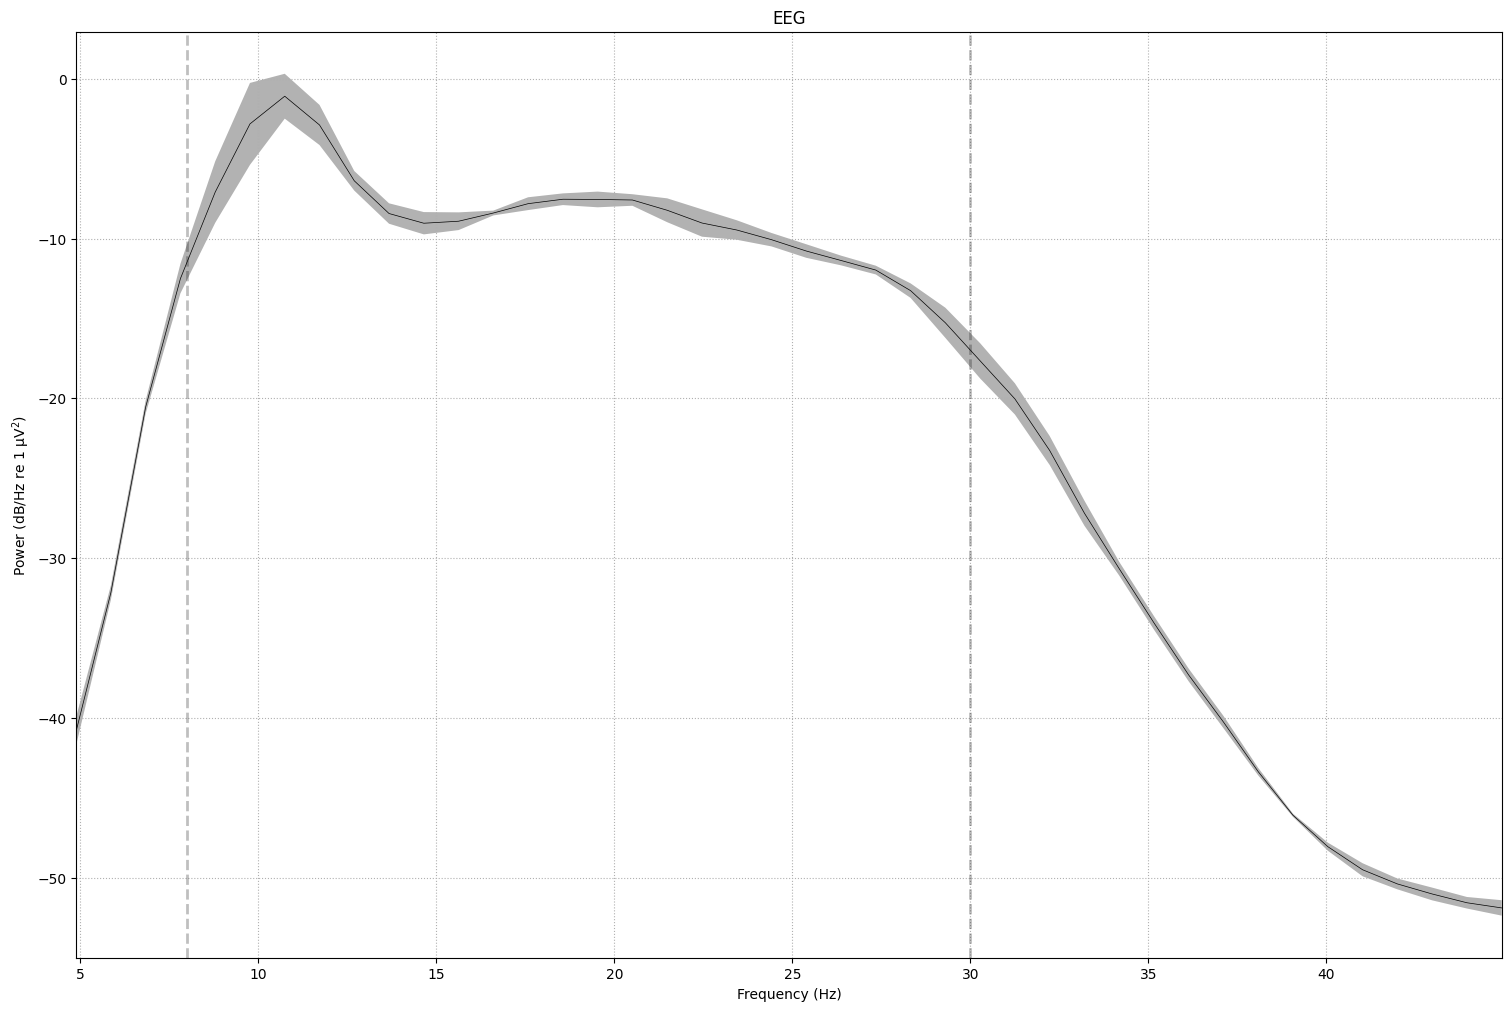

In [81]:
# Calcular la PSD con el método Welch 
epo_spectrum = epochs_2b.compute_psd(method='welch', fmin=4, fmax=45, n_fft=256)

# Obtener datos PSD y sus frecuencias
psds, freqs = epo_spectrum.get_data(return_freqs=True)
print(f"PSDs shape: {psds.shape}, freqs shape: {freqs.shape}")

# Graficar el PSD promedio sobre todos los epochs (por canal)
# average=True: promedio de los 288 trials (no cada trial individual).
fig=epo_spectrum.plot(average=True, dB=True, spatial_colors=True)
fig.set_size_inches(15, 10)
plt.show()

In [82]:
# Calcular TFR para cada clase MI y visualizar ERD/ERS usando mu/beta - Database 2b
# VERIFICACIÓN: Confirmar mapeo correcto de clases
# 'class 1' (evento 7) = Left hand (mano izquierda) → tfr_left_2b ✓
# 'class 2' (evento 8) = Right hand (mano derecha) → tfr_right_2b ✓

print("Creando TFR para análisis de ERD/ERS - Database 2b:")
print(f"  tfr_left_2b ← epochs_2b['class 1'] (Left hand, evento {mi_event_id_2b['class 1']})")
print(f"  tfr_right_2b ← epochs_2b['class 2'] (Right hand, evento {mi_event_id_2b['class 2']})")
print()

freqs_2b = np.arange(8., 31., 1.)
n_cycles_2b = freqs_2b / 2.0

tfr_left_2b = epochs_2b['class 1'].compute_tfr(method='morlet', freqs=freqs_2b, n_cycles=n_cycles_2b, use_fft=True, return_itc=False, decim=3, average=True)
tfr_right_2b = epochs_2b['class 2'].compute_tfr(method='morlet', freqs=freqs_2b, n_cycles=n_cycles_2b, use_fft=True, return_itc=False, decim=3, average=True)

print(f"✓ TFR creados exitosamente:")
print(f"  tfr_left_2b: {len(epochs_2b['class 1'])} trials de MI izquierda")
print(f"  tfr_right_2b: {len(epochs_2b['class 2'])} trials de MI derecha")

for tfr_object in (tfr_left_2b, tfr_right_2b):
    tfr_object.apply_baseline(baseline=(-0.5, 0), mode='logratio')

# Crear gráficos TFR/espectrogramas comparando MI izquierda vs derecha para C3 y C4 - Database 2b
c3_idx_2b = [i for i, ch in enumerate(tfr_left_2b.ch_names) if 'C3' in ch][0]
c4_idx_2b = [i for i, ch in enumerate(tfr_left_2b.ch_names) if 'C4' in ch][0]

# TFR para C3: comparación izquierda vs derecha (espectrogramas lado a lado) - Database 2b
fig_c3_2b, axes_c3_2b = plt.subplots(1, 2, figsize=(16, 6))

# C3 - MI Izquierda
c3_left_data_2b = tfr_left_2b.data[c3_idx_2b, :, :]
im1_2b = axes_c3_2b[0].imshow(c3_left_data_2b, aspect='auto', origin='lower',
                        extent=[tfr_left_2b.times[0], tfr_left_2b.times[-1], freqs_2b[0], freqs_2b[-1]],
                        cmap='RdBu_r', vmin=-0.8, vmax=0.8)
axes_c3_2b[0].axvline(x=0, color='k', linestyle='--', alpha=0.5, linewidth=2)
axes_c3_2b[0].set_title('C3: MI Izquierda (2b)', fontsize=12, fontweight='bold')
axes_c3_2b[0].set_xlabel('Tiempo (s)')
axes_c3_2b[0].set_ylabel('Frecuencia (Hz)')
plt.colorbar(im1_2b, ax=axes_c3_2b[0], label='Log-ratio power')

# C3 - MI Derecha
c3_right_data_2b = tfr_right_2b.data[c3_idx_2b, :, :]
im2_2b = axes_c3_2b[1].imshow(c3_right_data_2b, aspect='auto', origin='lower',
                        extent=[tfr_right_2b.times[0], tfr_right_2b.times[-1], freqs_2b[0], freqs_2b[-1]],
                        cmap='RdBu_r', vmin=-0.8, vmax=0.8)
axes_c3_2b[1].axvline(x=0, color='k', linestyle='--', alpha=0.5, linewidth=2)
axes_c3_2b[1].set_title('C3: MI Derecha (2b)', fontsize=12, fontweight='bold')
axes_c3_2b[1].set_xlabel('Tiempo (s)')
axes_c3_2b[1].set_ylabel('Frecuencia (Hz)')
plt.colorbar(im2_2b, ax=axes_c3_2b[1], label='Log-ratio power')

plt.suptitle('C3: Comparación MI Izquierda vs Derecha (8-30 Hz) - Database 2b', fontsize=14, fontweight='bold')
plt.tight_layout()
_save_figure(fig_c3_2b, 'tfr_C3_left_vs_right_2b.png')
plt.close(fig_c3_2b)

# TFR para C4: comparación izquierda vs derecha (espectrogramas lado a lado) - Database 2b
fig_c4_2b, axes_c4_2b = plt.subplots(1, 2, figsize=(16, 6))

# C4 - MI Izquierda
c4_left_data_2b = tfr_left_2b.data[c4_idx_2b, :, :]
im3_2b = axes_c4_2b[0].imshow(c4_left_data_2b, aspect='auto', origin='lower',
                        extent=[tfr_left_2b.times[0], tfr_left_2b.times[-1], freqs_2b[0], freqs_2b[-1]],
                        cmap='RdBu_r', vmin=-0.8, vmax=0.8)
axes_c4_2b[0].axvline(x=0, color='k', linestyle='--', alpha=0.5, linewidth=2)
axes_c4_2b[0].set_title('C4: MI Izquierda (2b)', fontsize=12, fontweight='bold')
axes_c4_2b[0].set_xlabel('Tiempo (s)')
axes_c4_2b[0].set_ylabel('Frecuencia (Hz)')
plt.colorbar(im3_2b, ax=axes_c4_2b[0], label='Log-ratio power')

# C4 - MI Derecha
c4_right_data_2b = tfr_right_2b.data[c4_idx_2b, :, :]
im4_2b = axes_c4_2b[1].imshow(c4_right_data_2b, aspect='auto', origin='lower',
                        extent=[tfr_right_2b.times[0], tfr_right_2b.times[-1], freqs_2b[0], freqs_2b[-1]],
                        cmap='RdBu_r', vmin=-0.8, vmax=0.8)
axes_c4_2b[1].axvline(x=0, color='k', linestyle='--', alpha=0.5, linewidth=2)
axes_c4_2b[1].set_title('C4: MI Derecha (2b)', fontsize=12, fontweight='bold')
axes_c4_2b[1].set_xlabel('Tiempo (s)')
axes_c4_2b[1].set_ylabel('Frecuencia (Hz)')
plt.colorbar(im4_2b, ax=axes_c4_2b[1], label='Log-ratio power')

plt.suptitle('C4: Comparación MI Izquierda vs Derecha (8-30 Hz) - Database 2b', fontsize=14, fontweight='bold')
plt.tight_layout()
_save_figure(fig_c4_2b, 'tfr_C4_left_vs_right_2b.png')
plt.close(fig_c4_2b)



Creando TFR para análisis de ERD/ERS - Database 2b:
  tfr_left_2b ← epochs_2b['class 1'] (Left hand, evento 10)
  tfr_right_2b ← epochs_2b['class 2'] (Right hand, evento 11)

✓ TFR creados exitosamente:
  tfr_left_2b: 60 trials de MI izquierda
  tfr_right_2b: 60 trials de MI derecha
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
tfr_C3_left_vs_right_2b.png guardado en outputs/tfr_C3_left_vs_right_2b.png
tfr_C4_left_vs_right_2b.png guardado en outputs/tfr_C4_left_vs_right_2b.png


### Laboratory analisis

In [94]:
# Carga de datos - Recording de Adriana
raw_lab = mne.io.read_raw_gdf('Real_time_signal_ADRIANA.gdf', preload=True)

# Elimina cualquier canal marcado como EOG para que solo queden EEG
eog_channels_adriana = [name for name in raw_lab.info['ch_names'] if 'EOG' in name.upper()]
if eog_channels_adriana:
    raw_lab.drop_channels(eog_channels_adriana)
print("Canales EEG después de eliminar EOG:", raw_lab.ch_names)
print("\nInformación del raw:")
print(raw_lab.info)

Extracting EDF parameters from /Users/miguel_05/Desktop/Academico/Universidad/Octavo Ciclo/NeuroMotionXR_pipeline/Real_time_signal_ADRIANA.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8
Creating raw.info structure...
Reading 0 ... 66015  =      0.000 ...   264.060 secs...
Canales EEG después de eliminar EOG: ['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'Channel 5', 'Channel 6', 'Channel 7', 'Channel 8']

Información del raw:
<Info | 8 non-empty values
 bads: []
 ch_names: Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel ...
 chs: 8 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: X, last_name: >
>


/var/folders/7g/x1f_2rpx6slblmnprfxv_0yr0000gn/T/ipykernel_28032/2014399648.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_lab = mne.io.read_raw_gdf('Real_time_signal_ADRIANA.gdf', preload=True)


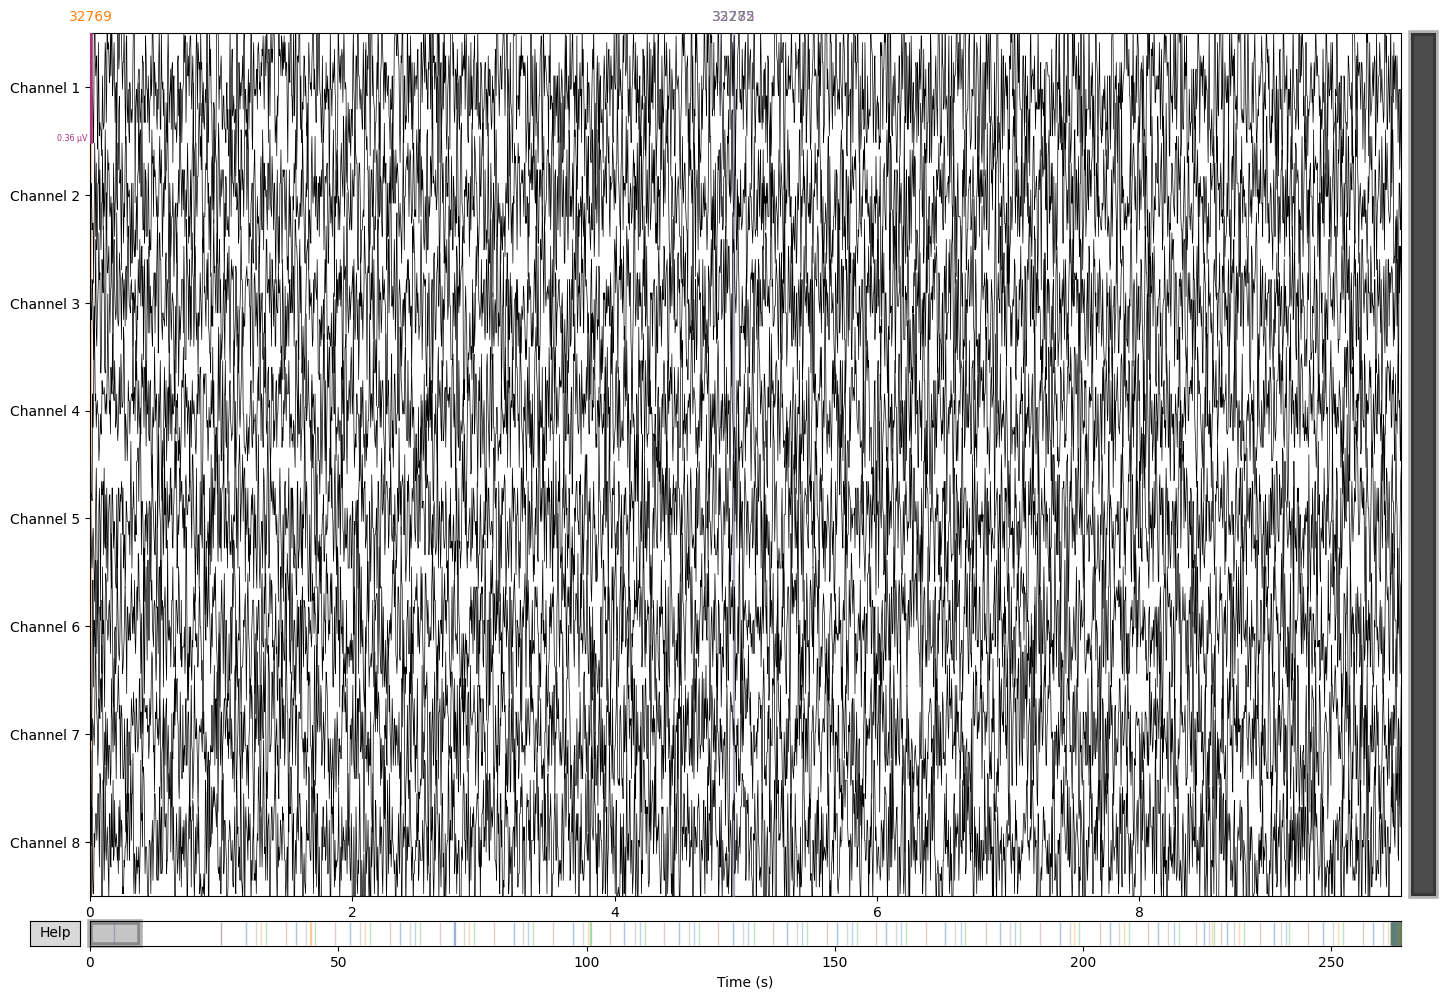

In [96]:
# Plot de la DATA CRUDA - Recording de Adriana
fig = raw_lab.plot(scalings='auto', show=False)
fig.set_size_inches(15, 10)
plt.show()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



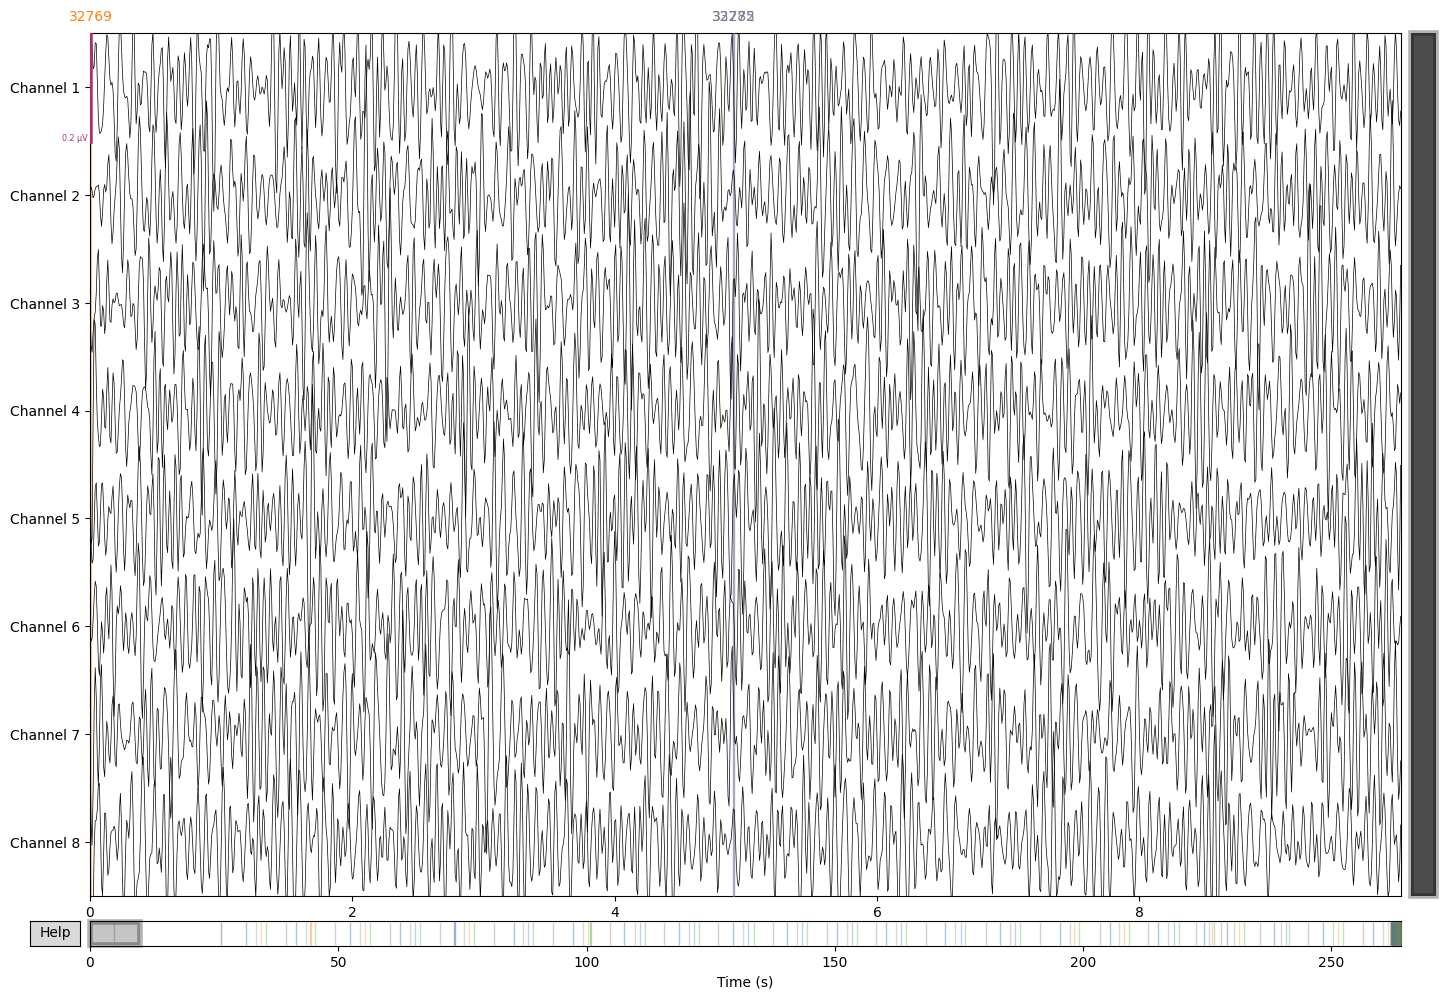

In [98]:
# Filtrado - Recording de Adriana
raw_lab.filter(l_freq=8, h_freq=30, method='iir')
raw_lab.notch_filter(freqs=50)

# Plot de la data filtrada
fig = raw_lab.plot(scalings='auto', show=False)
fig.set_size_inches(15, 10)
plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/opt/anaconda3/envs/dl_env/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


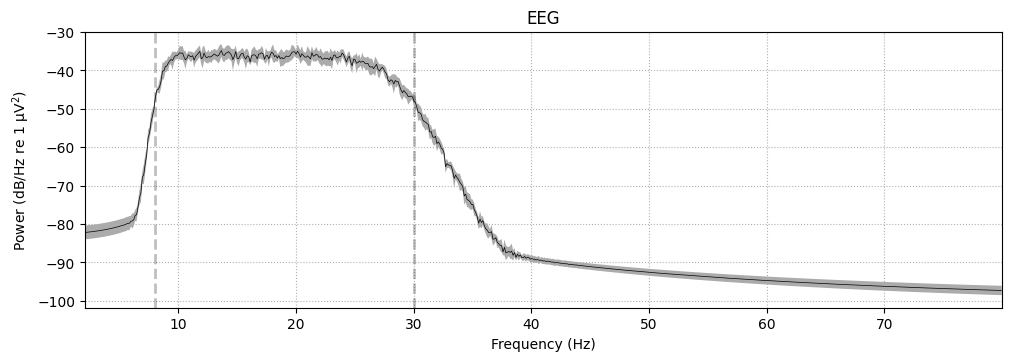

In [99]:
# PSD - Recording de Adriana
raw_lab.plot_psd(tmin=0, tmax=60, fmin=2, fmax=80, average=True, spatial_colors=False);
plt.show()

In [100]:
# Convierte las anotaciones textuales en eventos numéricos - Recording de Adriana
events_adriana = mne.events_from_annotations(raw_lab)
print("Anotaciones disponibles:", events_adriana[1])

# Definir el diccionario de eventos para Recording de Adriana
# Evento 769 (mapeado a 10) = Left hand (mano izquierda) → 'class 1'
# Evento 770 (mapeado a 11) = Right hand (mano derecha) → 'class 2'
event_dict_adriana = {
    'class 1': 10,  # Left hand (evento 769)
    'class 2': 11,  # Right hand (evento 770)
}

# Crear diccionario solo con eventos MI
mi_event_id_adriana = {name: idx for name, idx in event_dict_adriana.items() if name.startswith('class')}
print('Eventos MI disponibles (Adriana):', mi_event_id_adriana)

Used Annotations descriptions: ['1010', '32769', '32770', '32775', '32776', '33281', '33282', '33284', '768', '769', '770', '781', '786', '800']
Anotaciones disponibles: {'1010': 1, '32769': 2, '32770': 3, '32775': 4, '32776': 5, '33281': 6, '33282': 7, '33284': 8, '768': 9, '769': 10, '770': 11, '781': 12, '786': 13, '800': 14}
Eventos MI disponibles (Adriana): {'class 1': 10, 'class 2': 11}


In [101]:
# Crear epochs para los eventos de interés (clases MI) incluyendo 0.5 s pre-evento - Recording de Adriana
epochs_adriana = mne.Epochs(raw_lab, events_adriana[0], event_id=mi_event_id_adriana, tmin=-0.5, tmax=4, reject=None, baseline=None, preload=True)

# Extraer los datos y las etiquetas de las epochs
first_session_data_adriana = epochs_adriana.get_data(copy=True)

# Etiquetas de las primeras sesiones
first_session_labels_adriana = epochs_adriana.events[:,-1]

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 1126 original time points ...
18 bad epochs dropped


In [102]:
# VERIFICACIÓN: Contar cuántos trials hay de cada clase y confirmar el mapeo correcto - Recording de Adriana
print("="*80)
print("VERIFICACIÓN DE ETIQUETAS Y DISTRIBUCIÓN DE CLASES - Recording de Adriana")
print("="*80)
print(f"\nTotal de epochs: {len(epochs_adriana)}")
print(f"\nDistribución por clase:")
for class_name, class_id in mi_event_id_adriana.items():
    count = np.sum(first_session_labels_adriana == class_id)
    print(f"  {class_name} (evento {class_id}): {count} trials ({count/len(epochs_adriana)*100:.1f}%)")

# Según la documentación del BCI Competition IV 2b (similar para Adriana):
# Evento 769 (mapeado a 10) = Left hand (mano izquierda) → 'class 1'
# Evento 770 (mapeado a 11) = Right hand (mano derecha) → 'class 2'

print("\n" + "="*80)
print("MAPEO DE CLASES - Recording de Adriana:")
print("="*80)
print("  Class 1 (evento 10, original 769) → Left hand (mano izquierda)")
print("  Class 2 (evento 11, original 770) → Right hand (mano derecha)")
print("="*80)

# Verificar que tenemos suficientes trials de cada clase de interés
class_1_count_adriana = np.sum(first_session_labels_adriana == mi_event_id_adriana['class 1'])
class_2_count_adriana = np.sum(first_session_labels_adriana == mi_event_id_adriana['class 2'])

print(f"\nVerificación para análisis:")
print(f"  'class 1' (Left hand): {class_1_count_adriana} trials → Se usará como 'MI izquierda'")
print(f"  'class 2' (Right hand): {class_2_count_adriana} trials → Se usará como 'MI derecha'")

if class_1_count_adriana == 0 or class_2_count_adriana == 0:
    print("\n⚠️  ADVERTENCIA: Una de las clases no tiene trials!")
else:
    print(f"\n✓ Verificación exitosa: Ambas clases tienen suficientes trials para el análisis")
print("="*80)

# Verificación adicional: Mostrar algunos ejemplos de eventos para confirmar
print("\nEjemplos de eventos (primeros 10):")
print("Tiempo (s)\tEvento ID\tClase")
for i in range(min(10, len(epochs_adriana.events))):
    event_time = epochs_adriana.events[i, 0] / epochs_adriana.info['sfreq']
    event_id = epochs_adriana.events[i, 2]
    class_name = [name for name, eid in mi_event_id_adriana.items() if eid == event_id]
    class_name = class_name[0] if class_name else 'unknown'
    print(f"{event_time:.2f}\t\t{event_id}\t\t{class_name}")


VERIFICACIÓN DE ETIQUETAS Y DISTRIBUCIÓN DE CLASES - Recording de Adriana

Total de epochs: 22

Distribución por clase:
  class 1 (evento 10): 12 trials (54.5%)
  class 2 (evento 11): 10 trials (45.5%)

MAPEO DE CLASES - Recording de Adriana:
  Class 1 (evento 10, original 769) → Left hand (mano izquierda)
  Class 2 (evento 11, original 770) → Right hand (mano derecha)

Verificación para análisis:
  'class 1' (Left hand): 12 trials → Se usará como 'MI izquierda'
  'class 2' (Right hand): 10 trials → Se usará como 'MI derecha'

✓ Verificación exitosa: Ambas clases tienen suficientes trials para el análisis

Ejemplos de eventos (primeros 10):
Tiempo (s)	Evento ID	Clase
34.40		11		class 2
44.41		11		class 2
55.43		11		class 2
65.40		10		class 1
76.36		11		class 2
88.28		10		class 1
100.24		11		class 2
110.74		10		class 1
121.60		10		class 1
132.56		10		class 1


Effective window size : 1.024 (s)
PSDs shape: (288, 22, 42), freqs shape: (42,)
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


/opt/anaconda3/envs/dl_env/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


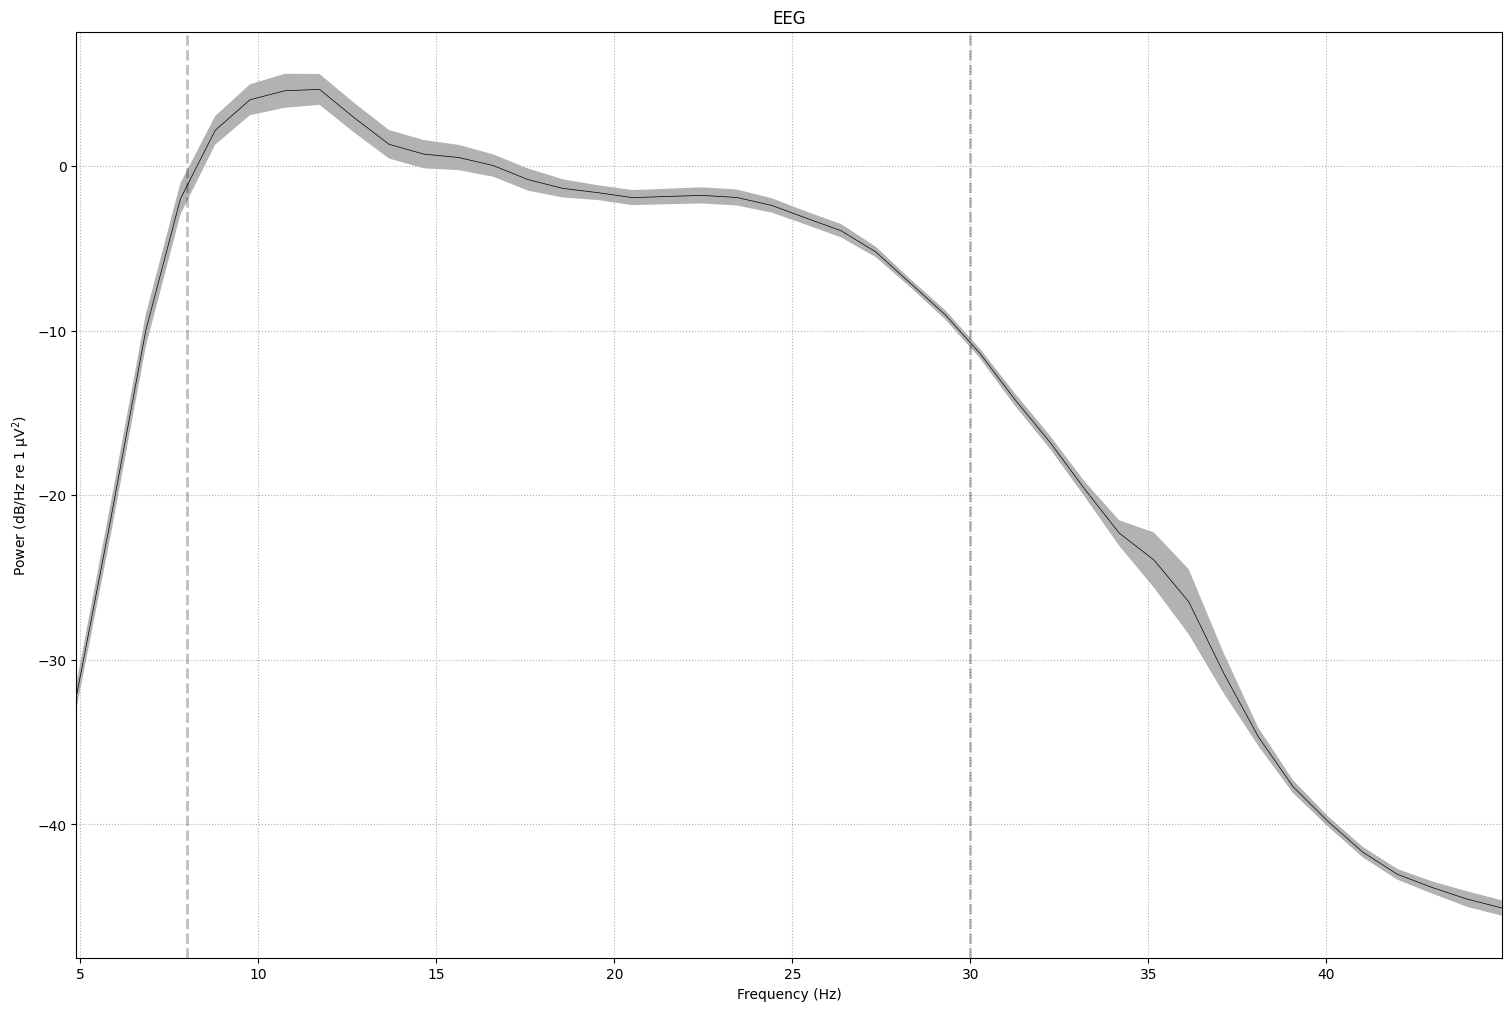

In [103]:
# Calcular la PSD con el método Welch 
epo_spectrum_adriana = epochs.compute_psd(method='welch', fmin=4, fmax=45, n_fft=256)

# Obtener datos PSD y sus frecuencias
psds, freqs = epo_spectrum_adriana.get_data(return_freqs=True)
print(f"PSDs shape: {psds.shape}, freqs shape: {freqs.shape}")

# Graficar el PSD promedio sobre todos los epochs (por canal)
# average=True: promedio de los 288 trials (no cada trial individual).
fig=epo_spectrum_adriana.plot(average=True, dB=True, spatial_colors=True)
fig.set_size_inches(15, 10)
plt.show()


In [106]:
# Calcular TFR para cada clase MI y visualizar ERD/ERS usando mu/beta - Recording de Adriana
# VERIFICACIÓN: Confirmar mapeo correcto de clases
# 'class 1' (evento 10) = Left hand (mano izquierda) → tfr_left_adriana ✓
# 'class 2' (evento 11) = Right hand (mano derecha) → tfr_right_adriana ✓

print("Creando TFR para análisis de ERD/ERS - Recording de Adriana:")
print(f"  tfr_left_adriana ← epochs_adriana['class 1'] (Left hand, evento {mi_event_id_adriana['class 1']})")
print(f"  tfr_right_adriana ← epochs_adriana['class 2'] (Right hand, evento {mi_event_id_adriana['class 2']})")
print()

freqs_adriana = np.arange(8., 31., 1.)
n_cycles_adriana = freqs_adriana / 2.0

tfr_left_adriana = epochs_adriana['class 1'].compute_tfr(method='morlet', freqs=freqs_adriana, n_cycles=n_cycles_adriana, use_fft=True, return_itc=False, decim=3, average=True)
tfr_right_adriana = epochs_adriana['class 2'].compute_tfr(method='morlet', freqs=freqs_adriana, n_cycles=n_cycles_adriana, use_fft=True, return_itc=False, decim=3, average=True)

print(f"✓ TFR creados exitosamente:")
print(f"  tfr_left_adriana: {len(epochs_adriana['class 1'])} trials de MI izquierda")
print(f"  tfr_right_adriana: {len(epochs_adriana['class 2'])} trials de MI derecha")

for tfr_object in (tfr_left_adriana, tfr_right_adriana):
    tfr_object.apply_baseline(baseline=(-0.5, 0), mode='logratio')

# Identificar canales centrales (asumiendo que los canales centrales son los del medio)
# En sistemas de 8 canales, normalmente Channel 3, 4, 5 corresponden a C3, Cz, C4
# Buscamos canales que puedan corresponder a C3 y C4
print(f"\nCanales disponibles: {tfr_left_adriana.ch_names}")

# Intentar encontrar canales con nombres que contengan 'C3' o 'C4', o usar índices centrales
c3_idx_adriana = None
c4_idx_adriana = None

# Buscar por nombre primero
for i, ch in enumerate(tfr_left_adriana.ch_names):
    if 'C3' in ch.upper() or '3' in ch:
        c3_idx_adriana = i
    if 'C4' in ch.upper() or '4' in ch:
        c4_idx_adriana = i

# Si no se encuentran por nombre, usar índices centrales (asumiendo Channel 3 = C3, Channel 5 = C4)
if c3_idx_adriana is None:
    # Asumir que Channel 3 (índice 2) es C3
    if len(tfr_left_adriana.ch_names) >= 3:
        c3_idx_adriana = 2  # Channel 3
        print(f"Usando índice {c3_idx_adriana} ({tfr_left_adriana.ch_names[c3_idx_adriana]}) como C3")

if c4_idx_adriana is None:
    # Asumir que Channel 5 (índice 4) es C4
    if len(tfr_left_adriana.ch_names) >= 5:
        c4_idx_adriana = 4  # Channel 5
        print(f"Usando índice {c4_idx_adriana} ({tfr_left_adriana.ch_names[c4_idx_adriana]}) como C4")

# Si aún no hay, usar los canales centrales disponibles
if c3_idx_adriana is None:
    c3_idx_adriana = len(tfr_left_adriana.ch_names) // 2 - 1
    print(f"Usando índice {c3_idx_adriana} ({tfr_left_adriana.ch_names[c3_idx_adriana]}) como canal izquierdo central")

if c4_idx_adriana is None:
    c4_idx_adriana = len(tfr_left_adriana.ch_names) // 2 + 1
    if c4_idx_adriana >= len(tfr_left_adriana.ch_names):
        c4_idx_adriana = len(tfr_left_adriana.ch_names) - 1
    print(f"Usando índice {c4_idx_adriana} ({tfr_left_adriana.ch_names[c4_idx_adriana]}) como canal derecho central")

print(f"\nCanales seleccionados para análisis:")
print(f"  Canal izquierdo (C3-like): {tfr_left_adriana.ch_names[c3_idx_adriana]} (índice {c3_idx_adriana})")
print(f"  Canal derecho (C4-like): {tfr_left_adriana.ch_names[c4_idx_adriana]} (índice {c4_idx_adriana})")


Creando TFR para análisis de ERD/ERS - Recording de Adriana:
  tfr_left_adriana ← epochs_adriana['class 1'] (Left hand, evento 10)
  tfr_right_adriana ← epochs_adriana['class 2'] (Right hand, evento 11)

✓ TFR creados exitosamente:
  tfr_left_adriana: 12 trials de MI izquierda
  tfr_right_adriana: 10 trials de MI derecha
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)

Canales disponibles: ['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'Channel 5', 'Channel 6', 'Channel 7', 'Channel 8']

Canales seleccionados para análisis:
  Canal izquierdo (C3-like): Channel 3 (índice 2)
  Canal derecho (C4-like): Channel 4 (índice 3)


In [107]:
# Crear gráficos TFR/espectrogramas comparando MI izquierda vs derecha para canales centrales - Recording de Adriana
# TFR para canal izquierdo (C3-like): comparación izquierda vs derecha (espectrogramas lado a lado)
fig_c3_adriana, axes_c3_adriana = plt.subplots(1, 2, figsize=(16, 6))

# Canal izquierdo - MI Izquierda
c3_left_data_adriana = tfr_left_adriana.data[c3_idx_adriana, :, :]
im1_adriana = axes_c3_adriana[0].imshow(c3_left_data_adriana, aspect='auto', origin='lower',
                        extent=[tfr_left_adriana.times[0], tfr_left_adriana.times[-1], freqs_adriana[0], freqs_adriana[-1]],
                        cmap='RdBu_r', vmin=-0.8, vmax=0.8)
axes_c3_adriana[0].axvline(x=0, color='k', linestyle='--', alpha=0.5, linewidth=2)
axes_c3_adriana[0].set_title(f'{tfr_left_adriana.ch_names[c3_idx_adriana]}: MI Izquierda (Adriana)', fontsize=12, fontweight='bold')
axes_c3_adriana[0].set_xlabel('Tiempo (s)')
axes_c3_adriana[0].set_ylabel('Frecuencia (Hz)')
plt.colorbar(im1_adriana, ax=axes_c3_adriana[0], label='Log-ratio power')

# Canal izquierdo - MI Derecha
c3_right_data_adriana = tfr_right_adriana.data[c3_idx_adriana, :, :]
im2_adriana = axes_c3_adriana[1].imshow(c3_right_data_adriana, aspect='auto', origin='lower',
                        extent=[tfr_right_adriana.times[0], tfr_right_adriana.times[-1], freqs_adriana[0], freqs_adriana[-1]],
                        cmap='RdBu_r', vmin=-0.8, vmax=0.8)
axes_c3_adriana[1].axvline(x=0, color='k', linestyle='--', alpha=0.5, linewidth=2)
axes_c3_adriana[1].set_title(f'{tfr_right_adriana.ch_names[c3_idx_adriana]}: MI Derecha (Adriana)', fontsize=12, fontweight='bold')
axes_c3_adriana[1].set_xlabel('Tiempo (s)')
axes_c3_adriana[1].set_ylabel('Frecuencia (Hz)')
plt.colorbar(im2_adriana, ax=axes_c3_adriana[1], label='Log-ratio power')

plt.suptitle(f'{tfr_left_adriana.ch_names[c3_idx_adriana]}: Comparación MI Izquierda vs Derecha (8-30 Hz) - Recording de Adriana', fontsize=14, fontweight='bold')
plt.tight_layout()
_save_figure(fig_c3_adriana, 'tfr_C3_left_vs_right_adriana.png')
plt.close(fig_c3_adriana)

# TFR para canal derecho (C4-like): comparación izquierda vs derecha (espectrogramas lado a lado)
fig_c4_adriana, axes_c4_adriana = plt.subplots(1, 2, figsize=(16, 6))

# Canal derecho - MI Izquierda
c4_left_data_adriana = tfr_left_adriana.data[c4_idx_adriana, :, :]
im3_adriana = axes_c4_adriana[0].imshow(c4_left_data_adriana, aspect='auto', origin='lower',
                        extent=[tfr_left_adriana.times[0], tfr_left_adriana.times[-1], freqs_adriana[0], freqs_adriana[-1]],
                        cmap='RdBu_r', vmin=-0.8, vmax=0.8)
axes_c4_adriana[0].axvline(x=0, color='k', linestyle='--', alpha=0.5, linewidth=2)
axes_c4_adriana[0].set_title(f'{tfr_left_adriana.ch_names[c4_idx_adriana]}: MI Izquierda (Adriana)', fontsize=12, fontweight='bold')
axes_c4_adriana[0].set_xlabel('Tiempo (s)')
axes_c4_adriana[0].set_ylabel('Frecuencia (Hz)')
plt.colorbar(im3_adriana, ax=axes_c4_adriana[0], label='Log-ratio power')

# Canal derecho - MI Derecha
c4_right_data_adriana = tfr_right_adriana.data[c4_idx_adriana, :, :]
im4_adriana = axes_c4_adriana[1].imshow(c4_right_data_adriana, aspect='auto', origin='lower',
                        extent=[tfr_right_adriana.times[0], tfr_right_adriana.times[-1], freqs_adriana[0], freqs_adriana[-1]],
                        cmap='RdBu_r', vmin=-0.8, vmax=0.8)
axes_c4_adriana[1].axvline(x=0, color='k', linestyle='--', alpha=0.5, linewidth=2)
axes_c4_adriana[1].set_title(f'{tfr_right_adriana.ch_names[c4_idx_adriana]}: MI Derecha (Adriana)', fontsize=12, fontweight='bold')
axes_c4_adriana[1].set_xlabel('Tiempo (s)')
axes_c4_adriana[1].set_ylabel('Frecuencia (Hz)')
plt.colorbar(im4_adriana, ax=axes_c4_adriana[1], label='Log-ratio power')

plt.suptitle(f'{tfr_left_adriana.ch_names[c4_idx_adriana]}: Comparación MI Izquierda vs Derecha (8-30 Hz) - Recording de Adriana', fontsize=14, fontweight='bold')
plt.tight_layout()
_save_figure(fig_c4_adriana, 'tfr_C4_left_vs_right_adriana.png')
plt.close(fig_c4_adriana)


tfr_C3_left_vs_right_adriana.png guardado en outputs/tfr_C3_left_vs_right_adriana.png
tfr_C4_left_vs_right_adriana.png guardado en outputs/tfr_C4_left_vs_right_adriana.png
